In [11]:
import numpy as np
import pandas as pd
import seaborn as sns


from sklearn.neighbors import LocalOutlierFactor
from sklearn.metrics import f1_score, accuracy_score, matthews_corrcoef, precision_score, roc_auc_score, recall_score, average_precision_score
from tqdm import tqdm
from matplotlib import pyplot as plt

from IPython.display import clear_output

In [12]:
y_train = pd.read_csv('../fraud_detection/active_datasets/y_train.csv', header=None).to_numpy().ravel()
y_test = pd.read_csv('../fraud_detection/active_datasets/y_test.csv', header=None).to_numpy().ravel()

In [13]:
bbb_test = pd.read_csv('../fraud_detection/active_datasets/bbb_test.csv', header=None).to_numpy()
bcb_test = pd.read_csv('../fraud_detection/active_datasets/bcb_test.csv', header=None).to_numpy()
fff_test = pd.read_csv('../fraud_detection/active_datasets/fff_test.csv', header=None).to_numpy()
fcf_test = pd.read_csv('../fraud_detection/active_datasets/fcf_test.csv', header=None).to_numpy()

In [14]:
def score(y_pred, y_true):
        scores = {}
        evaluation_funcs = {'accuracy':accuracy_score, 'precision':precision_score, 'recall':recall_score, 'f1':f1_score, 'MCC':matthews_corrcoef}
        for name, score in evaluation_funcs.items():
                scores[name] = score(y_pred = y_pred, y_true = y_test)
        scores['ROC-AUC'] = roc_auc_score(y_score = y_pred, y_true = y_test)
        scores['AUPR'] = average_precision_score(y_score = y_pred, y_true = y_test)
        return scores

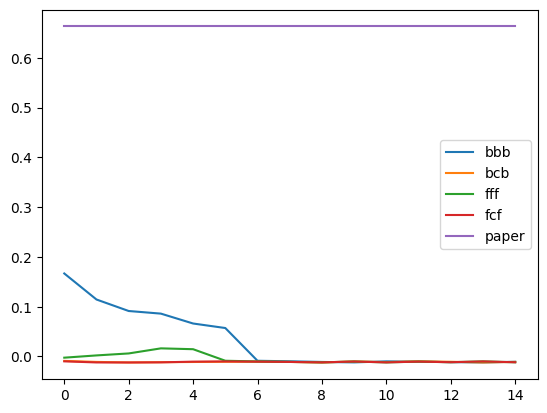

  2%|▏         | 15/999 [07:07<7:56:48, 29.07s/it]

In [15]:
bbb_scores = []
bcb_scores = []
fff_scores = []
fcf_scores = []

for k in tqdm(range(1, 1000)) :
    LOF = LocalOutlierFactor(n_neighbors = k, contamination=sum(y_train)/len(y_train))
    bbb_pred = LOF.fit_predict(bbb_test)
    bbb_pred = list(map(lambda x: {-1:1, 1:0}[x], bbb_pred))
    bbb_scores.append(score(bbb_pred, y_test))

    LOF = LocalOutlierFactor(n_neighbors = k, contamination=sum(y_train)/len(y_train))  
    bcb_pred = LOF.fit_predict(bcb_test)
    bcb_pred = list(map(lambda x: {-1:1, 1:0}[x], bcb_pred))
    bcb_scores.append(score(bcb_pred, y_test))

    LOF = LocalOutlierFactor(n_neighbors = k, contamination=sum(y_train)/len(y_train))
    fff_pred = LOF.fit_predict(fff_test)
    fff_pred = list(map(lambda x: {-1:1, 1:0}[x],fff_pred))
    fff_scores.append(score(fff_pred, y_test))

    LOF = LocalOutlierFactor(n_neighbors = k, contamination=sum(y_train)/len(y_train))                                       
    fcf_pred = LOF.fit_predict(fcf_test)
    fcf_pred = list(map(lambda x: {-1:1, 1:0}[x], fcf_pred))
    fcf_scores.append(score(fcf_pred, y_test))

    clear_output(True)
    sns.lineplot([bbb['recall'] for bbb in bbb_scores], label = 'bbb')
    sns.lineplot([bcb['recall'] for bcb in bcb_scores], label = 'bcb')
    sns.lineplot([fff['recall'] for fff in fff_scores], label = 'fff')
    sns.lineplot([fcf['recall'] for fcf in fcf_scores], label = 'fcf')
    sns.lineplot([.81495 for _ in range(k)], label = 'paper')
    plt.show()
